## 1 Setup and Data Loading

### 1.1 Importing Dependencies  
The following libraries are imported for data processing, visualization, and model building:  
- `pandas` and `numpy` for data manipulation.  
- `matplotlib` for visualization.  
- `tensorflow` for building and training the deep learning model.  
- `gradio` for creating an interactive interface.  

In [108]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report ConfusionMatrixDisplay

import gradio as gr

### 1.2 Loading Data
-----
- Reading dataset from CSV file
- Inspecting Structure of DataFrame
- Example Comment review
- Toxicity levels of example comment

In [4]:
df = pd.read_csv("/kaggle/working/CommentToxicity/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv")

In [5]:
#DataFrame Structure
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
#Example Comment
print(df.iloc[10]["comment_text"])

"
Fair use rationale for Image:Wonju.jpg

Thanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.

Please go to the image description page and edit it to include a fair use rationale.

If you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of 'image' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such an explanat

In [7]:
#Toxicity Labels of Example Comment
df[df.columns[2:]].iloc[10]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 10, dtype: int64

Label distribution:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


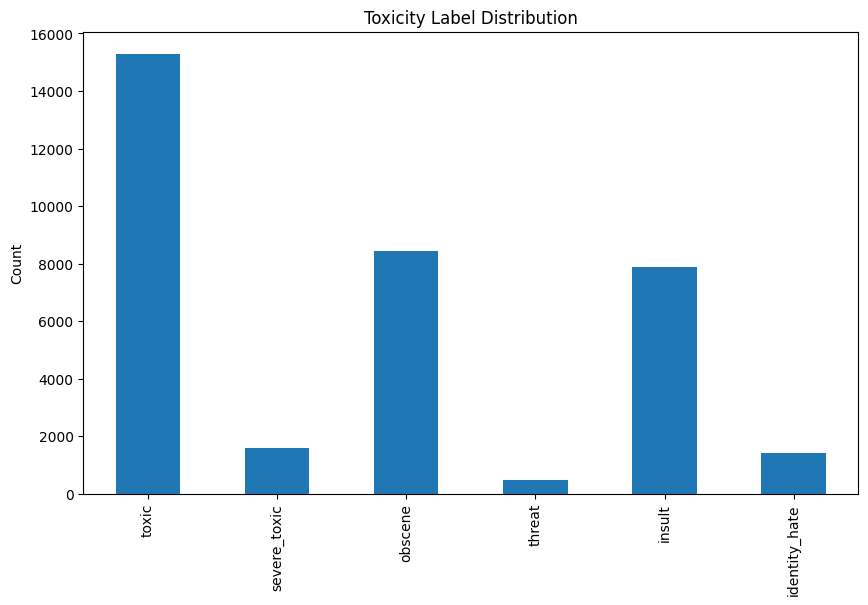

In [83]:
print("Label distribution:")
print(df[df.columns[2:]].sum())

plt.figure(figsize=(10,6))
df[df.columns[2:]].sum().plot(kind='bar')
plt.title("Toxicity Label Distribution")
plt.ylabel("Count")
plt.show()

## 2 Preprocessing Data


### 2.1 Vectorizing Text  
The `TextVectorization` layer converts raw text into numerical representations (tokens) for model input.  
- `max_tokens=200000`: Limits the vocabulary size to the top 200,000 words.  
- `output_sequence_length=1800`: Pads/truncates sequences to 1800 tokens.  
- `output_mode='int'`: Outputs integer-encoded sequences.  

In [8]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [9]:
MAX_FEATURES = 200000 # number of words in the vocab

In [60]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [61]:
vectorizer.adapt(X.values)

In [84]:
print(f"Vocabulary size: {len(vectorizer.get_vocabulary())}")
print(f"Coverage of top 20k words: {len(vectorizer.get_vocabulary()) / 200000 * 100:.2f}%")

Vocabulary size: 200000
Coverage of top 20k words: 100.00%


In [86]:
sample_text = "This is an example comment"
print(f"Original: {sample_text}")
print(f"Vectorized: {vectorizer(sample_text)[:5]}")

Original: This is an example comment
Vectorized: [ 14   9  30 310 204]


### 2.2 Splitting Data  
The dataset is split into training (70%), validation (20%), and test (10%) sets. The pipeline includes:  
1. **Shuffling**: Randomizes the data to avoid order bias.  
2. **Batching**: Groups data into batches of 16 samples for efficient training.  
3. **Prefetching**: Overlaps data preprocessing and model execution for performance.  


In [66]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(128)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [67]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [68]:
print("Dataset Size: ",len(dataset)*16)
print("-------------")
print("Training Set Size: ",len(train)*16)
print("Validation Set Size: ",len(val)*16)
print("Test Set Size: ",len(test)*16)

Dataset Size:  19952
-------------
Training Set Size:  13952
Validation Set Size:  3984
Test Set Size:  1984


### 3. Model Architecture  
The model consists of:  
- **Embedding Layer**: Converts tokenized text into dense vectors.  
- **Bidirectional LSTM**: Captures contextual relationships in both directions.  
- **Dense Layers**: Extract higher-level features (`relu` activation).  
- **Output Layer**: Uses `sigmoid` for multi-label classification (6 toxicity labels).  

In [19]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

### 3.2 Model Compiling
**Note**:  
- `BinaryCrossentropy` is used since each label is independent (multi-label problem).  
- `Adam` optimizer adapts learning rates dynamically for efficient training.  

In [20]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

### 3.3 Model Summary

In [69]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 1800, 32)            │       6,400,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,491,688 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### 3.4 Model Training

In [22]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10


I0000 00:00:1745142269.431105      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


872/872 ━━━━━━━━━━━━━━━━━━━━ 106s 111ms/step - loss: 0.1263 - val_loss: 0.0454
Epoch 2/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 94s 108ms/step - loss: 0.0462 - val_loss: 0.0412
Epoch 3/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 94s 108ms/step - loss: 0.0412 - val_loss: 0.0382
Epoch 4/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 94s 108ms/step - loss: 0.0379 - val_loss: 0.0358
Epoch 5/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 94s 108ms/step - loss: 0.0348 - val_loss: 0.0336
Epoch 6/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 94s 108ms/step - loss: 0.0320 - val_loss: 0.0293
Epoch 7/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 94s 108ms/step - loss: 0.0299 - val_loss: 0.0252
Epoch 8/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 94s 108ms/step - loss: 0.0256 - val_loss: 0.0239
Epoch 9/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 94s 108ms/step - loss: 0.0235 - val_loss: 0.0210
Epoch 10/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 94s 108ms/step - loss: 0.0208 - val_loss: 0.0178


**The Reason the loss started so low was becuase i had already trained the model for an additional 10 epochs prior**

### 4 Plotting Model Training History
**Training History**: Plot shows loss and metrics over epochs to diagnose overfitting.  
__________________
**Model Architecture**: Shows model layers in sequence. 
______________________
**Confusion Matrix**: Shows True labels VS Predicted Labels.

### 4.1 Model Loss Plot

<Figure size 2000x1200 with 0 Axes>

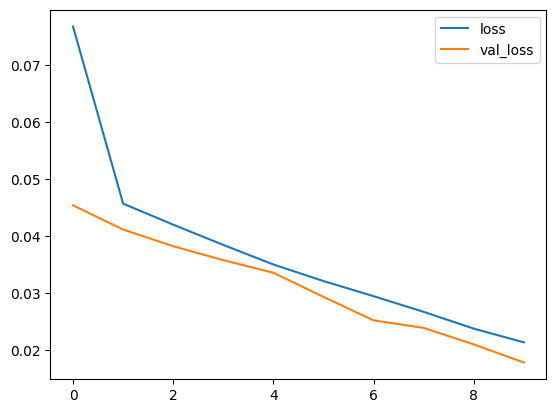

In [23]:
plt.figure(figsize=(10,6),dpi=200)
pd.DataFrame(history.history).plot()
plt.savefig("training_history.png")

### 4.2 Model Architecture Diagram

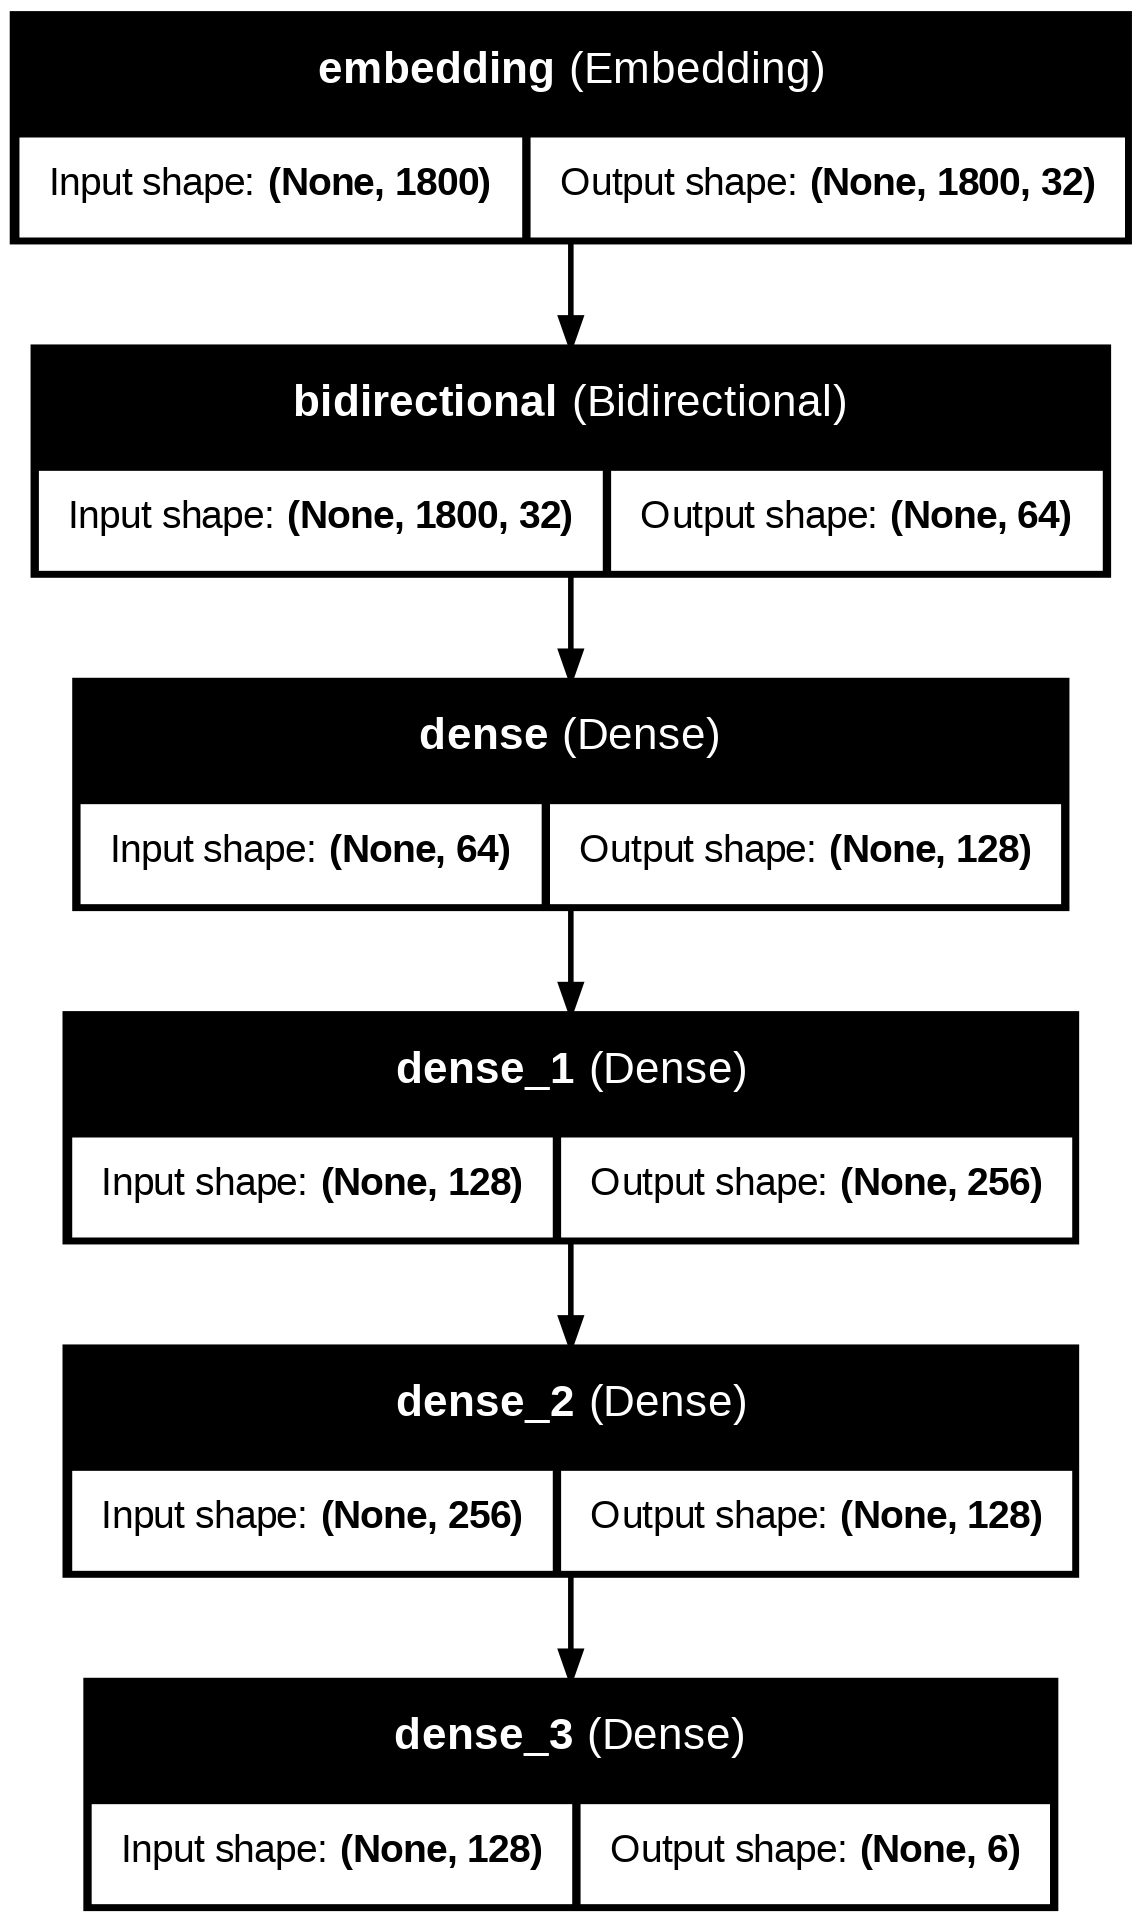

In [92]:
plot_model(model, show_shapes=True, show_layer_names=True,to_file="model_architecture.png")

### 4.3 Confusion Matrix

In [99]:
y_true = []
y_pred = []
for batch in test.as_numpy_iterator():
    X, y = batch
    y_true.extend(y)
    y_pred.extend(model.predict(X) > 0.5)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━

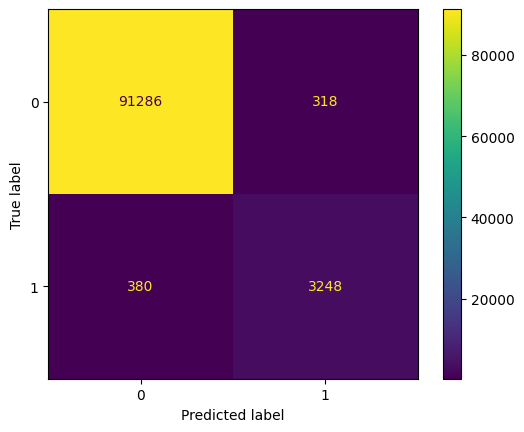

In [110]:
ConfusionMatrixDisplay.from_predictions(np.array(y_true).flatten(), np.array(y_pred).flatten())

## Model Evaluation
### Evaluation Metrics  
- **Precision**: Measures the model's ability to avoid false positives.  
- **Recall**: Measures the model's ability to detect all positive instances.  

In [ ]:
pre = Precision()
re = Recall()

In [73]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━

In [82]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}')

Precision: 0.9035911560058594, Recall:0.9006057381629944


## 6 Gradio App Demo
### Interactive Demo  
The Gradio interface allows users to input text and see real-time toxicity predictions.  
- **Input**: Textbox for user comments.  
- **Output**: Toxicity labels with binary scores (True/False).  

In [75]:
model.save('toxicity.h5')
model = tf.keras.models.load_model('toxicity.h5')

In [76]:
input_str = vectorizer('hey i freaken hate you!')

In [77]:
res = model.predict(np.expand_dims(input_str,0))
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


array([[0.85353816, 0.00321512, 0.07079747, 0.02096875, 0.71630985,
        0.11745387]], dtype=float32)

In [93]:
# Improved scoring function
def score_comment(comment):
    if not comment or not isinstance(comment, str):
        return "Please enter a valid text comment"
    
    try:
        vectorized_comment = vectorizer([comment])
        results = model.predict(vectorized_comment)
        
        text = 'Toxicity Analysis:\\n'
        for idx, col in enumerate(df.columns[2:]):
            text += '{}: {} ({:.2f}% confidence)\\n'.format(
                col, 
                results[0][idx] > 0.5,
                results[0][idx] * 100
            )
            
        return text
    except Exception as e:
        return f"Error processing comment: {str(e)}"

In [94]:
interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=2, placeholder="Comment to score"),
    outputs="text"
)


In [95]:
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7864
* Running on public URL: https://ac50f5fde4d3274b84.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
